In [1]:
import librosa
import librosa.feature
import librosa.display
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Conv1D, MaxPooling1D
from keras.utils.np_utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support as score

In [53]:
class stop_train_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.7 and logs.get('accuracy') > 0.95:
            print("\nReached 70% val accuracy so cancelling training!")
            self.model.stop_training = True

In [3]:
def display_mfcc(song):
    y, sample_rate = librosa.load(song)
    plt.plot(range(0, len(y)), y)
    plt.show()
    mfcc = librosa.feature.mfcc(y)

    fur = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(fur), ref=np.max)
    plt.figure()
    librosa.display.specshow(S_db)
    plt.colorbar()

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title(song)
    plt.tight_layout()
    plt.show()

In [4]:
def extract_features_song(f):
    y, _ = librosa.load(f)
    mfcc = librosa.feature.mfcc(y)
    mfcc /= np.amax(np.absolute(mfcc))
    return np.ndarray.flatten(mfcc)[:25000]

In [5]:
def generate_features_and_labels():
    all_features = []
    all_labels = []

    global genres
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

    for genre in genres:
        sound_files = glob.glob('genres/'+genre+'/*.au')
        print('Processing %d songs in %s genre...' % (len(sound_files), genre))
        for f in sound_files:
            features = extract_features_song(f)
            all_features.append(features)
            all_labels.append(genre)

    # convert labels to one-hot encoding
    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
    label_row_ids = label_row_ids.astype(np.int32, copy=False)
    onehot_labels = to_categorical(label_row_ids, len(label_uniq_ids))
    return np.stack(all_features), onehot_labels


In [6]:
features, labels = generate_features_and_labels()

Processing 100 songs in blues genre...
Processing 100 songs in classical genre...
Processing 100 songs in country genre...
Processing 100 songs in disco genre...
Processing 100 songs in hiphop genre...
Processing 100 songs in jazz genre...
Processing 100 songs in metal genre...
Processing 100 songs in pop genre...
Processing 100 songs in reggae genre...
Processing 100 songs in rock genre...


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_34 (Conv1D)           (None, 24951, 64)         3264      
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 2495, 64)          0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 2446, 64)          204864    
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 244, 64)           0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 15616)             0         
_________________________________________________________________
dense_68 (Dense)             (None, 1024)              15991808  
_________________________________________________________________
dense_69 (Dense)             (None, 512)             

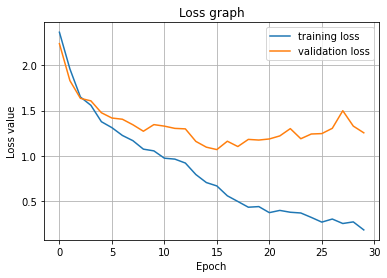

In [56]:
#display_mfcc('song2.wav')
epochs = 30
training_split = 0.8

# last column has genre, turn it into unique ids
all_data = np.column_stack((features, labels))

np.random.shuffle(all_data)
split_dx = int(len(all_data) * training_split)
train, test = all_data[:split_dx, :], all_data[split_dx:, :]

train_input = train[:, :-10]
train_labels = train[:, -10:]

test_input = test[:, :-10]
test_labels = test[:, -10:]

train_input = np.expand_dims(train_input, axis=2)
test_input = np.expand_dims(test_input, axis=2)

model = Sequential([
    Conv1D(64, 50, activation='relu', input_shape=np.shape(train_input)[1:]),
    MaxPooling1D(10),
    Conv1D(64, 50, activation='relu'),
    MaxPooling1D(10),
    Flatten(),
    Dense(1024, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
    Dense(256, activation='sigmoid'),
    Dense(10, activation='softmax'),
    ])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

model.fit(train_input, train_labels,
          batch_size=32,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[stop_train_callback()])

plt.title('Loss graph')
plt.plot(model.history.history['loss'], label='training loss')
plt.plot(model.history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.grid(True)
plt.legend()
plt.show()

7/7 [==============================] - 0s 29ms/step - loss: 0.9432 - accuracy: 0.7200
avg accuracy: 0.7200000286102295


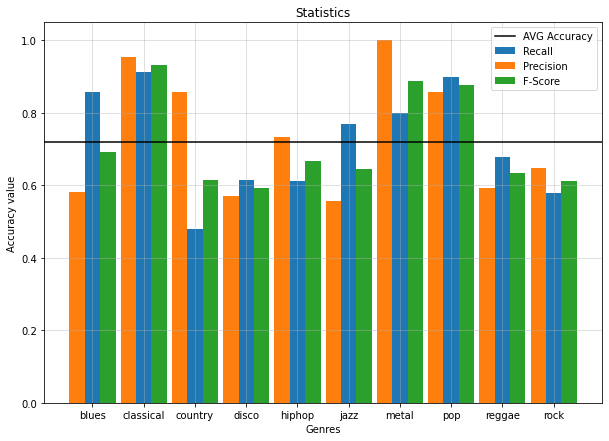

In [57]:
labels_indexes = np.argmax(test_labels, axis=1)
y_pred = model.predict(test_input)
pred_indexes = np.argmax(y_pred, axis=1)

precision, recall, f1, _ = score(labels_indexes, pred_indexes)
_, avg_acc = model.evaluate(test_input, test_labels)

print(f"avg accuracy: {avg_acc}")

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

w = 0.3
bar1 = np.arange(10)
bar2 = [i - w for i in bar1]
bar3 = [i + w for i in bar1]

ax.grid(True, alpha=0.5)
ax.bar(bar1, recall, width=w, label='Recall')
ax.bar(bar2, precision, width=w, label='Precision')
ax.bar(bar3, f1, width=w, label='F-Score')
ax.axhline(avg_acc, color='black', label='AVG Accuracy')
plt.title('Statistics')
plt.xlabel('Genres')
plt.ylabel('Accuracy value')
plt.legend()
plt.xticks(bar1, genres)
plt.show()

